In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import pyccl as ccl
from scipy.optimize import minimize
import emcee
import corner
import astropy.cosmology
import astropy.units as u
from chainconsumer import ChainConsumer
import pickle
import pandas as pd
import sacc
from scipy.stats import norm
from numpy.random import normal
from helper_functions import *

# Load data

In [2]:
javi_vector = load_sacc('sacc_cosmoDC2_i_lt_24p0_wcov.sacc')

In [3]:
ben_data = load_pkl('corr_cov/corrcov_truth_norandoms')

In [4]:
data_vector = [ben_data[0], ben_data[1], javi_vector[2]]

# Define Model

In [5]:
def model(pars, data, nz_out):
    Omega_m, Omega_b, sigma8, n_s, h, b1, b2, b3, b4, b5 = pars
    b = np.array([b1, b2, b3, b4, b5,])
    cosmo = ccl.Cosmology(Omega_b=Omega_b, Omega_c=Omega_m-Omega_b, n_s=n_s, h=h, sigma8=sigma8)
    return model_ccl_helper(data, b, nz_out, cosmo)

def prior(pars):
    Omega_m, Omega_b, sigma8, n_s, h, b1, b2, b3, b4, b5 = pars
    if (0.1 < Omega_m < 0.9) & \
    (.01 < Omega_b < 0.06) & \
    (0 < sigma8 < 2) & \
    (0.5 < n_s < 1.5) & \
    (0.1 < h < 1.5) & \
    (0 < b1 < 3) & \
    (0 < b2 < 3) & \
    (0 < b3 < 3) & \
    (0 < b4 < 3) & \
    (0 < b5 < 3):
        pr =  norm.pdf(Omega_m-Omega_b, 0.22, 0.2) *\
        norm.pdf(Omega_b, 0.0448, 0.006) *\
        norm.pdf(sigma8, 0.8, 0.14) *\
        norm.pdf(n_s, 0.963, 0.08) *\
        norm.pdf(h, 0.71, 0.063) *\
        norm.pdf(b1, 1.229, 0.9) *\
        norm.pdf(b2, 1.362, 0.9) *\
        norm.pdf(b3, 1.502, 0.9) *\
        norm.pdf(b4, 1.648, 0.9) *\
        norm.pdf(b5, 1.799, 0.9)
    
        return np.log(pr) 
    else:
        return -np.inf

In [6]:
angle_list = compute_scale_cuts(8500)
masks, inv_cov = preprocess(data_vector, angle_list)
tarr = [0.265, 0.0448, 0.8, 0.963, 0.71, 1.229, 1.362, 1.502, 1.648, 1.799]  
print(log_like(tarr, data_vector[0], data_vector[1], inv_cov, masks, model, prior))

/Users/Ben/Desktop/Blending Project/helper_functions.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  inv_cov = np.array([np.linalg.inv(cov[i][masks[i][0]:masks[i][-1]+1,


-356.79221904144265


# Run Chains

In [ ]:
run_emcee(data_vector, 'samples/chain_ben_example_Apr28', tarr, angle_list, model, prior, nsteps=100)

/Users/Ben/Desktop/Blending Project/helper_functions.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  inv_cov = np.array([np.linalg.inv(cov[i][masks[i][0]:masks[i][-1]+1,
  0%|                                                   | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▍                                          | 1/100 [00:01<01:51,  1.13s/it]/opt/anaconda3/envs/blending/lib/python3.10/site-packages/emcee/moves/r

# Plots and Analysis

In [7]:
chain_list = []
chain_list.append(np.load(f'samples/chain_ben_8500_norandoms_freeparams_Apr27.npy'))
chain_list.append(np.load(f'samples/chain_ben_txpipe_norandoms_freeparams_Apr27.npy'))
chain_list = np.array(chain_list)

parnames = ['$\\Omega_m$', '$\\Omega_b$', '$\\sigma_8$', '$n_s$', '$h$',
            '$b_1$', '$b_2$', '$b_3$', '$b_4$', '$b_5$',]

/var/folders/d1/k792r3jx2dnfdzf197jwm17m0000gn/T/ipykernel_34804/1505192307.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chain_list = np.array(chain_list)


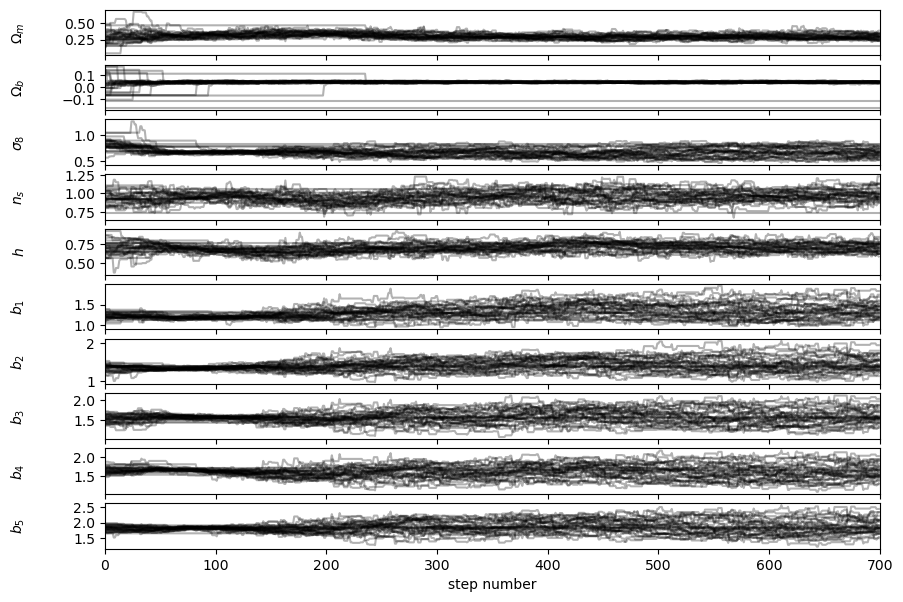

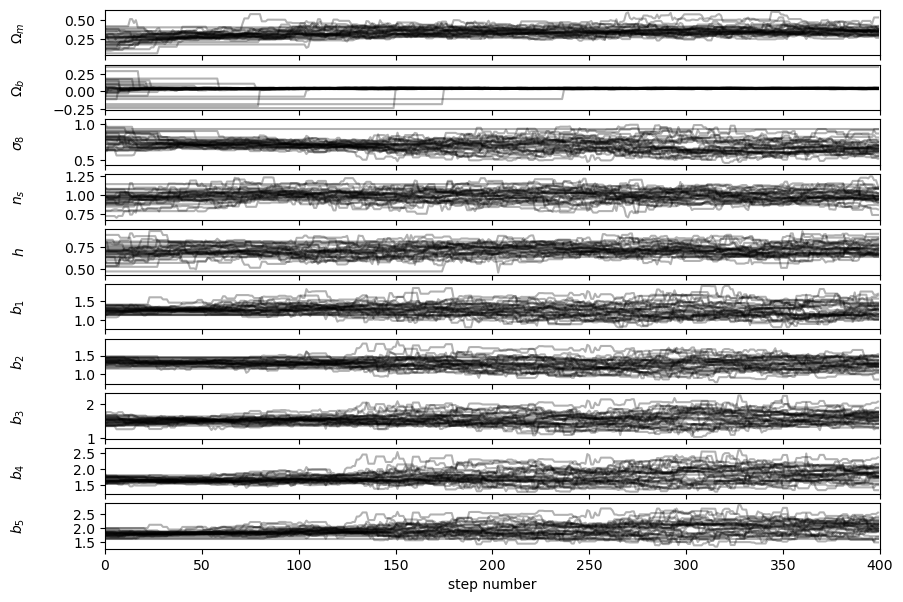

In [8]:
plot_convergence(chain_list, parnames)

In [9]:
chain_trimmed = []
chain_trimmed.append(process_stuck_chain(chain_list[0], 300))
chain_trimmed.append(process_stuck_chain(chain_list[1], 300))
chain_trimmed = np.array(chain_trimmed)

/var/folders/d1/k792r3jx2dnfdzf197jwm17m0000gn/T/ipykernel_34804/6829025.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chain_trimmed = np.array(chain_trimmed)


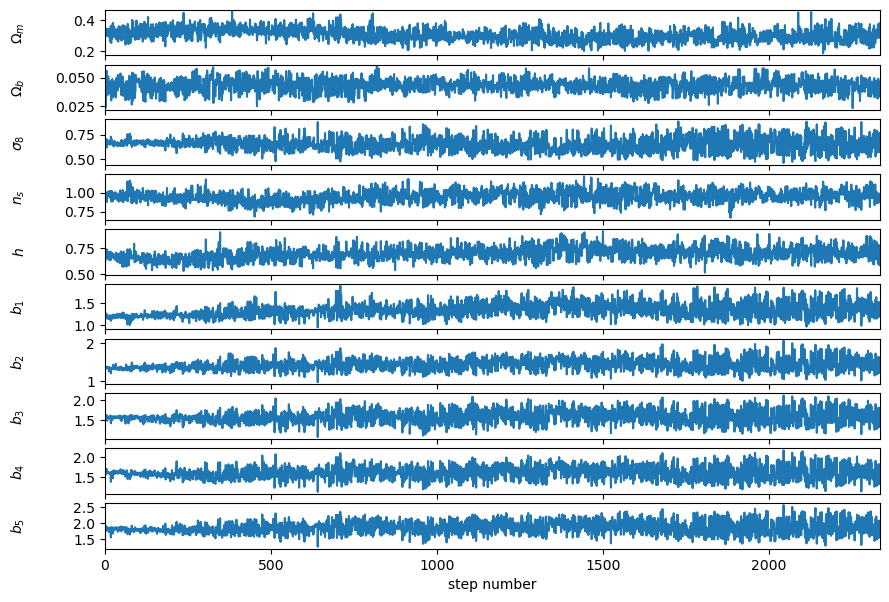

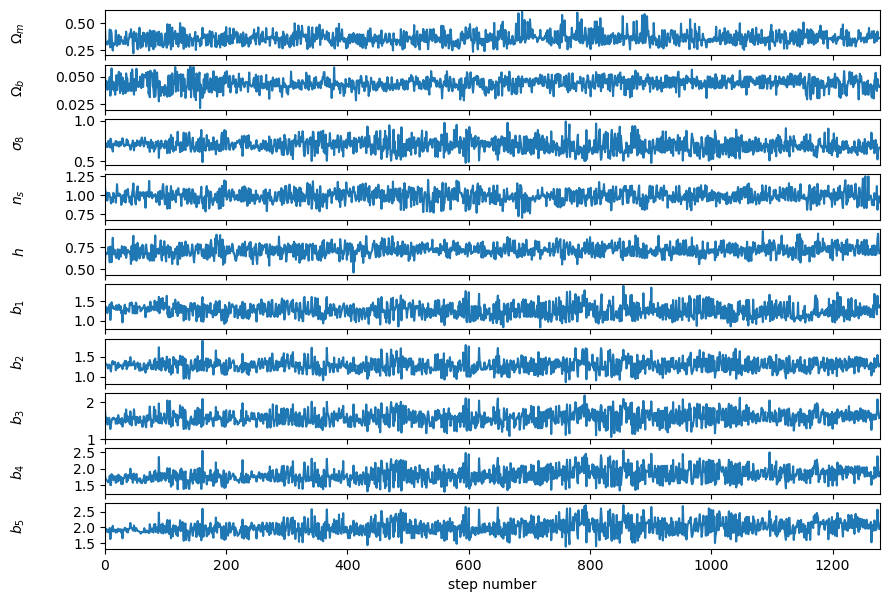

In [10]:
plot_convergence(chain_trimmed, parnames)

In [11]:
prior_list = np.array([normal(0.22+0.0448, 0.2, size=100000),
                       normal(0.0448, 0.006, size=100000),
                       normal(0.8, 0.14, size=100000),
                       normal(0.963, 0.08, size=100000),
                       normal(0.71, 0.063, size=100000),
                       normal(1.229, 0.9, size=100000),
                       normal(1.362, 0.9, size=100000),
                       normal(1.502, 0.9, size=100000),
                       normal(1.648, 0.9, size=100000),
                       normal(1.799, 0.9, size=100000),])

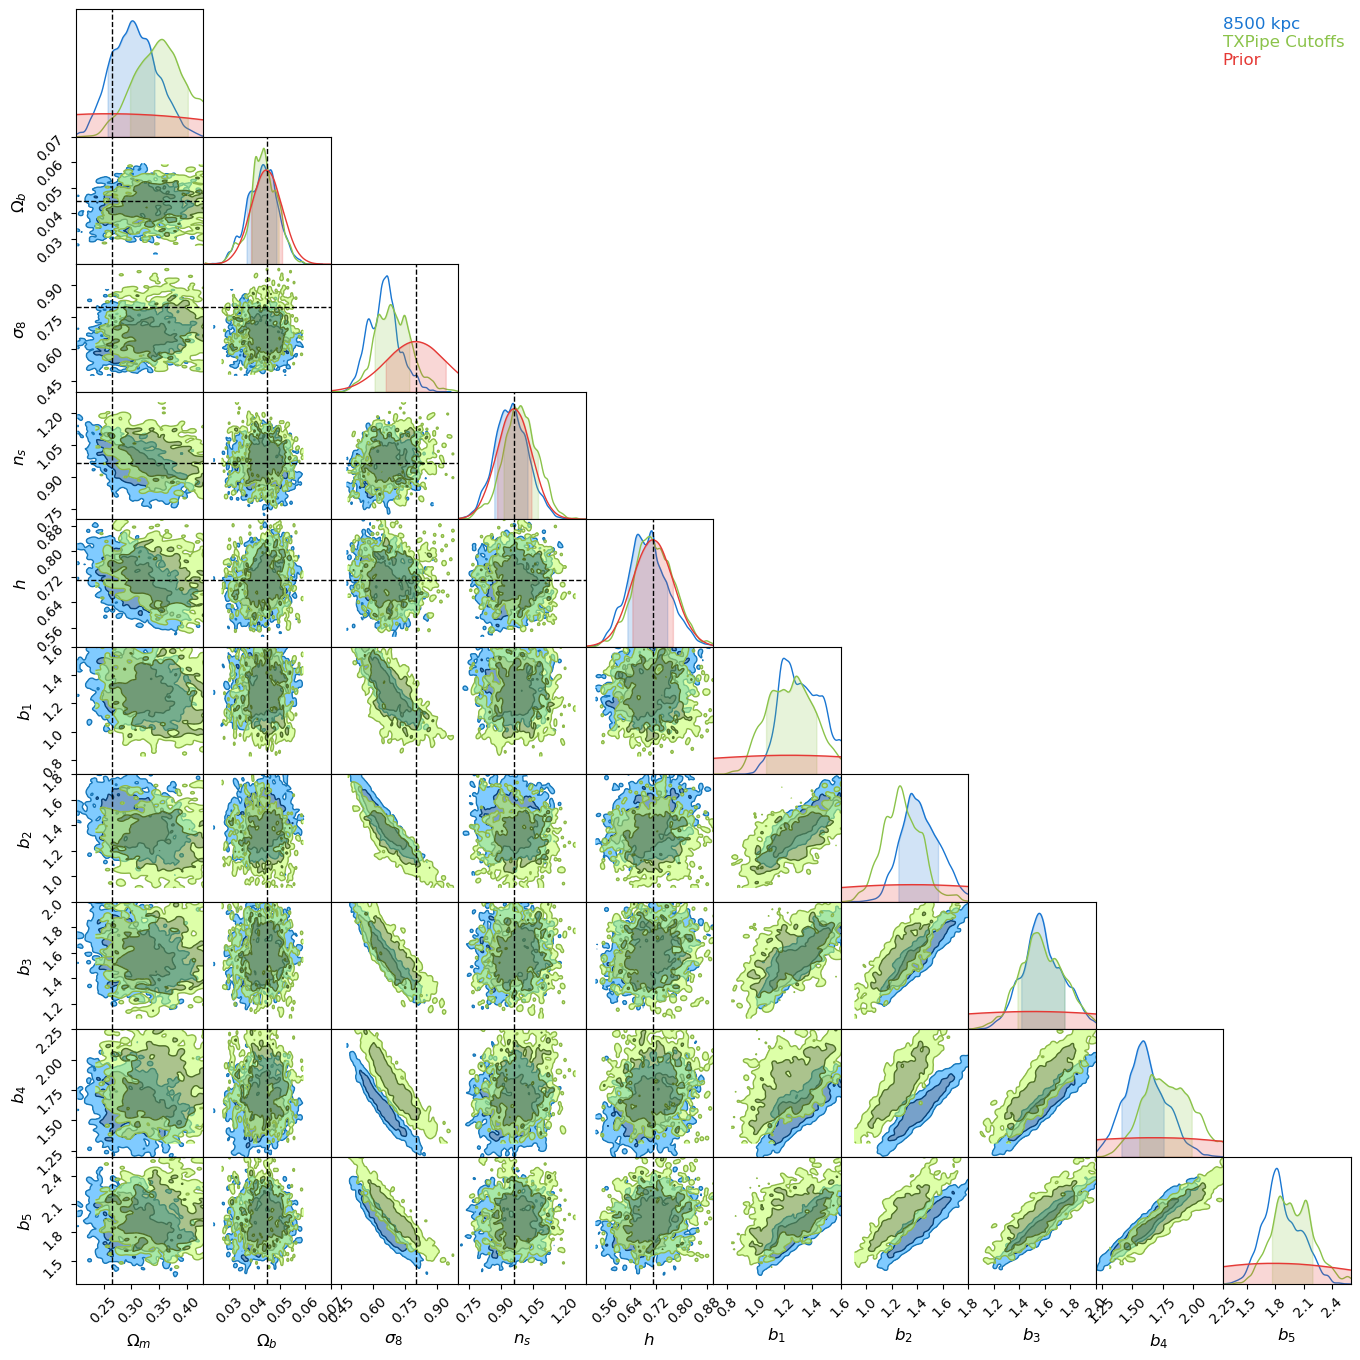

In [12]:
c = ChainConsumer()
names = ['8500 kpc', 'TXPipe Cutoffs']

for i in range(len(chain_list)):
    c.add_chain(chain_trimmed[i], parameters=parnames, name=names[i])
    
c.add_chain(prior_list.T, parameters=parnames, name="Prior", show_as_1d_prior=True)

c.configure(usetex=False, shade=True, bar_shade=True,)
# c.configure(usetex=False, shade=True, bar_shade=True, kde=True)
c.plotter.plot(truth=[0.265, 0.0448, 0.8, 0.963, 0.71],
               extents={"$\Omega_m$": (.2,.43),
                        "$\Omega_b$": (.02,.07),
                        "$\sigma_8$": (.4,1.0),
                        "$n_s$": (.7,1.3),
                        "$h$": (.5,.9),
                        "$b_1$": (.7,1.6),
                        "$b_2$": (.8,1.8),
                        "$b_3$": (1,2.0),
                        "$b_4$": (1.2,2.25),
                        "$b_5$": (1.25,2.6),
                       });

Best Fits: [0.30000548 0.04377811 0.66729291 0.95807545 0.70739133 1.19096972
 1.35140075 1.56225642 1.59549005 1.82259287]


/Users/Ben/Desktop/Blending Project/helper_functions.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  inv_cov = np.array([np.linalg.inv(cov[i][masks[i][0]:masks[i][-1]+1,


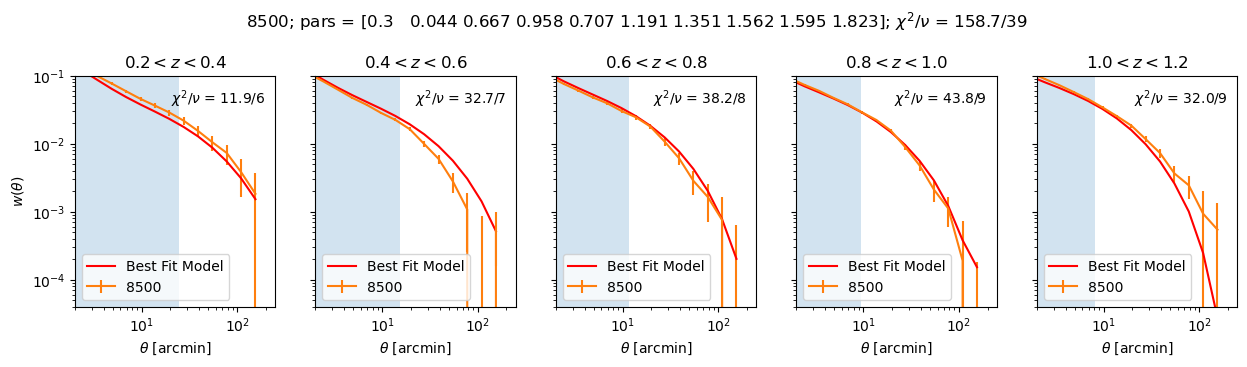

In [13]:
plot_model(data_vector, chain_trimmed[0], model, '8500', angle_list, parnames, fit_vals=None, color='C1')